# ***Install Libraries***

In [ ]:
!pip install panel==0.12.6 hvplot==0.7.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 4.8 MB/s 
     |████████████████████████████████| 3.1 MB 45.4 MB/s 
     |████████████████████████████████| 18.5 MB 51.1 MB/s 
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3
  Attempting uninstall: panel
    Found existing installation: panel 0.12.1
    Uninstalling panel-0.12.1:
      Successfully uninstalled panel-0.12.1


# ***Import Libraries***

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dependencies**

In [ ]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import data**

In [ ]:
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/loans.feather'
df = pd.read_feather(file_name)

**Preliminary cleaning**

In [ ]:
df = df.drop(['index'], axis=1)
df = df.replace(r'^\s*$', np.NaN, regex=True)
missing_data = df.isna().sum()
#missing_data = missing_data[missing_data != 0]
missing_data = missing_data.to_frame()
missing_data.columns = ["Qty"]
missing_data["Missing data (%)"] = missing_data["Qty"]/df.shape[0]*100
missing_data

,Qty,Missing data (%)
Unnamed: 0,0,0.000000
id,0,0.000000
loan_amnt,0,0.000000
funded_amnt,0,0.000000
funded_amnt_inv,0,0.000000
...,...,...
hardship_loan_status,2091974,93.680978
orig_projected_additional_accrued_interest,2056439,92.089681
hardship_payoff_balance_amount,2053926,91.977145
hardship_last_payment_amount,2053926,91.977145


**Replace cells with spaces to NaN**

Text(0, 0.5, 'Feature count')

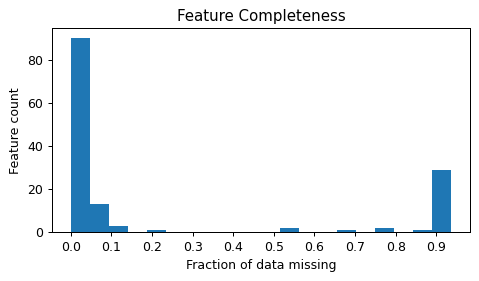

In [ ]:
xticks = np.arange(0, 100, 10)
plt.figure(figsize=(6,3), dpi=90)
missing_data["Missing data (%)"].plot.hist(bins=20)
plt.title('Feature Completeness')
plt.xlabel('Fraction of data missing')
plt.xticks(ticks=xticks, labels=xticks/100)
plt.ylabel('Feature count')

**Columns with more than 50% of missing data are eliminated**

In [ ]:
df = df.loc[:, df.isnull().mean() < .5]
df.shape

(2233083, 107)

**Some columns are transformed into the appropiate format**

In [ ]:
# int_rate str (10.21%) to float (10.21)
df['int_rate'] = df['int_rate'].str[:-1].astype(float)

# ***Data Cleaning***

In [ ]:
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233083 entries, 0 to 2233082
Data columns (total 107 columns):
 #    Column                      Dtype         
---   ------                      -----         
 0    Unnamed: 0                  int64         
 1    id                          int64         
 2    loan_amnt                   float64       
 3    funded_amnt                 float64       
 4    funded_amnt_inv             float64       
 5    term                        object        
 6    int_rate                    float64       
 7    installment                 float64       
 8    grade                       object        
 9    sub_grade                   object        
 10   emp_title                   object        
 11   emp_length                  object        
 12   home_ownership              object        
 13   annual_inc                  float64       
 14   verification_status         object        
 15   issue_d                     datetime64[ns]
 16 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233083 entries, 0 to 2233082
Columns: 107 entries, Unnamed: 0 to debt_settlement_flag
dtypes: datetime64[ns](1), float64(82), int64(2), object(22)
memory usage: 1.8+ GB


**Selection of missing context variables. there are 34, they will be imputed as explained in the document.**

In [ ]:
missing_data = df.isna().sum()
#missing_data = missing_data[missing_data != 0]
missing_data = missing_data.to_frame()
missing_data.columns = ["Qty"]
missing_data["Missing data (%)"] = missing_data["Qty"]/df.shape[0]*100
M_data = missing_data[missing_data["Qty"]>0].reset_index()
M_data

,index,Qty,Missing data (%)
0,emp_title,224586,10.057217
1,emp_length,172326,7.716955
2,title,23305,1.043624
3,zip_code,1,0.000045
4,dti,3108,0.139180
5,inq_last_6mths,1,0.000045
6,revol_util,2233,0.099996
7,last_pymnt_d,4400,0.197037
8,last_credit_pull_d,31,0.001388
9,open_acc_6m,173721,7.779424


**Categorical imputation**

In [ ]:
df["emp_length"].describe()
df["emp_title"]=df["emp_title"].replace(np.nan,"other")
df["emp_length"]=df["emp_length"].replace(np.nan,0) # change missing to 0 (think of a better option)
df["title"]=df["title"].replace(np.nan,"Other")
df["zip_code"]=df["zip_code"].replace(np.nan,0)
df["inq_last_6mths"]=df["inq_last_6mths"].replace(np.nan,0)
df["last_pymnt_d"]=pd.to_datetime(df["last_pymnt_d"])

In [ ]:
df["last_pymnt_d"]=pd.to_datetime(df["last_pymnt_d"])

In [ ]:
df["last_pymnt_d"].mode()

0   2020-05-01
dtype: datetime64[ns]

**As the 2020 dates are critical for pandemic I impute with the fashion that is not in pandemic.**

In [ ]:
df[df["last_pymnt_d"]!="2020-05-01"]["last_pymnt_d"].mode()

0   2019-07-01
dtype: datetime64[ns]

In [ ]:
df["last_pymnt_d"]=df["last_pymnt_d"].replace(np.nan,"2019-07-01")
df["last_credit_pull_d"]=pd.to_datetime(df["last_credit_pull_d"].replace(np.nan,"May-2020"))
df["hardship_flag"]=df["hardship_flag"].replace(np.nan,"N")

In [ ]:
df["hardship_flag"].mode()

0    N
dtype: object

In [ ]:
df["revol_util"]=df["revol_util"].str.replace("%","").astype("float")

In [ ]:
(df["dti"].describe()[4]+df["dti"].describe()[6])/2

18.765

**I define a function to impute the numeric columns**

In [ ]:
def impnume (a):
  b = math.trunc((a.describe()[4]+a.describe()[6])/2)
  a=a.replace(np.nan,b)
  return a

**Numerical allocations**

In [ ]:
df["dti"]=impnume(df["dti"])
df["revol_util"]=impnume(df["revol_util"])
df["open_acc_6m"]=impnume(df["open_acc_6m"])
df["open_act_il"]=impnume(df["open_act_il"])
df["open_il_12m"]=impnume(df["open_il_12m"])
df["open_il_24m"]=impnume(df["open_il_24m"])

In [ ]:
df["mths_since_rcnt_il"]=impnume(df["mths_since_rcnt_il"])
df["total_bal_il"]=impnume(df["total_bal_il"])
df["il_util"]=impnume(df["il_util"])
df["open_rv_12m"]=impnume(df["open_rv_12m"])
df["open_rv_24m"]=impnume(df["open_rv_24m"])
df["max_bal_bc"]=impnume(df["max_bal_bc"])

In [ ]:
df["all_util"]=impnume(df["all_util"])
df["inq_fi"]=impnume(df["inq_fi"])
df["total_cu_tl"]=impnume(df["total_cu_tl"])
df["inq_last_12m"]=impnume(df["inq_last_12m"])
df["avg_cur_bal"]=impnume(df["avg_cur_bal"])
df["bc_open_to_buy"]=impnume(df["bc_open_to_buy"])

In [ ]:
df["bc_util"]=impnume(df["bc_util"])
df["mo_sin_old_il_acct"]=impnume(df["mo_sin_old_il_acct"])
df["mths_since_recent_bc"]=impnume(df["mths_since_recent_bc"])
df["mths_since_recent_inq"]=impnume(df["mths_since_recent_inq"])
df["num_rev_accts"]=impnume(df["num_rev_accts"])
df["num_tl_120dpd_2m"]=impnume(df["num_tl_120dpd_2m"])

In [ ]:
df["pct_tl_nvr_dlq"]=impnume(df["pct_tl_nvr_dlq"])
df["percent_bc_gt_75"]=impnume(df["percent_bc_gt_75"])

In [ ]:
df["earliest_cr_line"]=pd.to_datetime(df["earliest_cr_line"])

In [ ]:
Mdict=pd.DataFrame(df.columns.values)

In [ ]:
dict_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/LCDataDictionary.xlsx'
dic = pd.read_excel(dict_name)

In [ ]:
Mdicti=dic.merge(Mdict, left_on="LoanStatNew",right_on=0).drop(0,axis=1)
Mdicti["Type"]=Mdicti["LoanStatNew"]

In [ ]:
Mdicti

,LoanStatNew,Description,Type
0,acc_now_delinq,The number of accounts on which the borrower i...,acc_now_delinq
1,acc_open_past_24mths,Number of trades opened in past 24 months.,acc_open_past_24mths
2,addr_state,The state provided by the borrower in the loan...,addr_state
3,all_util,Balance to credit limit on all trades,all_util
4,annual_inc,The self-reported annual income provided by th...,annual_inc
...,...,...,...
100,url,URL for the LC page with listing data.,url
101,verification_status,"Indicates if income was verified by LC, not ve...",verification_status
102,zip_code,The first 3 numbers of the zip code provided b...,zip_code
103,hardship_flag,Flags whether or not the borrower is on a hard...,hardship_flag


In [ ]:
def types (a):
  b=df[a].dtype
  return b

In [ ]:
Mdicti["Type"]=Mdicti["Type"].apply(types)

In [ ]:
pd.set_option('max_rows', 105)
Mdicti

,LoanStatNew,Description,Type
0,acc_now_delinq,The number of accounts on which the borrower i...,float64
1,acc_open_past_24mths,Number of trades opened in past 24 months.,float64
2,addr_state,The state provided by the borrower in the loan...,object
3,all_util,Balance to credit limit on all trades,float64
4,annual_inc,The self-reported annual income provided by th...,float64
5,application_type,Indicates whether the loan is an individual ap...,object
6,avg_cur_bal,Average current balance of all accounts,float64
7,bc_open_to_buy,Total open to buy on revolving bankcards.,float64
8,bc_util,Ratio of total current balance to high credit/...,float64
9,chargeoff_within_12_mths,Number of charge-offs within 12 months,float64


In [ ]:
Mdicti[Mdicti["Type"]=="object"]

,LoanStatNew,Description,Type
2,addr_state,The state provided by the borrower in the loan...,object
5,application_type,Indicates whether the loan is an individual ap...,object
16,emp_length,Employment length in years. Possible values ar...,object
17,emp_title,The job title supplied by the Borrower when ap...,object
22,grade,LC assigned loan grade,object
23,home_ownership,The home ownership status provided by the borr...,object
26,initial_list_status,The initial listing status of the loan. Possib...,object
39,loan_status,Current status of the loan,object
77,purpose,A category provided by the borrower for the lo...,object
78,pymnt_plan,Indicates if a payment plan has been put in pl...,object


In [ ]:
data_categorica=df[["addr_state","application_type","emp_length","emp_title","grade","home_ownership","initial_list_status","loan_status",
                    "purpose","pymnt_plan","sub_grade","term","title","url","verification_status",
                    "zip_code","hardship_flag","debt_settlement_flag"]]

In [ ]:
ncolumnas=list(Mdicti[Mdicti["Type"]=="float64"].reset_index().drop("index",axis=1)["LoanStatNew"])
data_numerica=df[ncolumnas]
data_numerica

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,...,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
0,0.0,7.0,53.0,42000.0,3389.0,7144.0,53.9,0.0,0.0000,0.0,...,30502.0,19045.0,15500.0,1.0,26180.0,13500.440000,13500.44,1500.44,0.00,12000.00
1,0.0,8.0,40.0,155000.0,22542.0,81313.0,34.5,0.0,0.0000,0.0,...,63891.0,15582.0,124200.0,2.0,20034.0,31838.670000,31838.67,5997.56,0.00,25841.11
2,0.0,4.0,22.0,120000.0,20682.0,51211.0,20.7,0.0,0.0000,0.0,...,154261.0,140872.0,64600.0,3.0,168145.0,30417.910000,30417.91,12794.81,0.00,17623.10
3,0.0,0.0,58.0,79077.0,10714.0,336.0,90.9,0.0,0.0000,0.0,...,128572.0,112355.0,3700.0,0.0,96918.0,15527.570000,15527.57,1983.00,0.00,13544.57
4,0.0,6.0,22.0,107000.0,9778.0,65368.0,20.0,0.0,0.0000,0.0,...,48219.0,29686.0,81700.0,1.0,73015.0,26616.930000,26616.93,3490.01,0.00,23126.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233078,0.0,8.0,25.0,107000.0,5528.0,20859.0,26.0,1.0,0.0000,1.0,...,60812.0,51124.0,28200.0,0.0,64422.0,7749.830000,7749.83,5188.42,0.00,2561.41
2233079,0.0,3.0,20.0,65000.0,3724.0,26229.0,24.6,0.0,0.0000,0.0,...,55863.0,46112.0,34800.0,0.0,70203.0,11233.834658,11233.83,1233.83,0.00,10000.00
2233080,0.0,9.0,47.0,37000.0,1021.0,3054.0,66.1,0.0,96.8166,0.0,...,14300.0,0.0,9000.0,0.0,0.0,9484.880000,9484.88,2522.65,0.00,6424.36
2233081,1.0,2.0,55.0,41000.0,3275.0,7651.0,5.5,0.0,0.0000,0.0,...,26201.0,24845.0,8100.0,0.0,34076.0,6917.541543,6917.54,917.54,0.00,6000.00


In [ ]:
def numerical (a):
  if a=="Charged Off":
    b=1
  elif a=="Current":
    b=2
  elif a=="Default":
    b=0
  elif a=="Fully Paid":
    b=3
  elif a=="In Grace Period":
    b=4
  elif a=="Issued":
    b=5
  elif a=="Late (16-30 days)":
    b=6
  elif a=="Late (31-120 days)":
    b=7
  else:
    b=8
  return b

In [ ]:
data_numerica["loan_status"]=data_categorica["loan_status"].apply(numerical)

In [ ]:
Corrnume=pd.DataFrame(data_numerica.corr()["loan_status"]).reset_index().head(82)

In [ ]:
Corrnume

,index,loan_status
0,acc_now_delinq,0.009959
1,acc_open_past_24mths,-0.007384
2,all_util,-0.016450
3,annual_inc,0.004224
4,avg_cur_bal,0.034159
5,bc_open_to_buy,0.006315
6,bc_util,-0.018581
7,chargeoff_within_12_mths,0.001944
8,collection_recovery_fee,-0.321985
9,collections_12_mths_ex_med,-0.002827


In [ ]:
dictinum=Mdicti[Mdicti["Type"]=="float64"].reset_index()

In [ ]:
dictinum["corr"]=Corrnume["loan_status"]
dictinum

,index,LoanStatNew,Description,Type,corr
0,0,acc_now_delinq,The number of accounts on which the borrower i...,float64,0.009959
1,1,acc_open_past_24mths,Number of trades opened in past 24 months.,float64,-0.007384
2,3,all_util,Balance to credit limit on all trades,float64,-0.016450
3,4,annual_inc,The self-reported annual income provided by th...,float64,0.004224
4,6,avg_cur_bal,Average current balance of all accounts,float64,0.034159
5,7,bc_open_to_buy,Total open to buy on revolving bankcards.,float64,0.006315
6,8,bc_util,Ratio of total current balance to high credit/...,float64,-0.018581
7,9,chargeoff_within_12_mths,Number of charge-offs within 12 months,float64,0.001944
8,10,collection_recovery_fee,post charge off collection fee,float64,-0.321985
9,11,collections_12_mths_ex_med,Number of collections in 12 months excluding m...,float64,-0.002827


In [ ]:
dictinum[np.abs(dictinum["corr"].astype(float))<=0.01]

,index,LoanStatNew,Description,Type,corr
0,0,acc_now_delinq,The number of accounts on which the borrower i...,float64,0.009959
1,1,acc_open_past_24mths,Number of trades opened in past 24 months.,float64,-0.007384
3,4,annual_inc,The self-reported annual income provided by th...,float64,0.004224
5,7,bc_open_to_buy,Total open to buy on revolving bankcards.,float64,0.006315
7,9,chargeoff_within_12_mths,Number of charge-offs within 12 months,float64,0.001944
9,11,collections_12_mths_ex_med,Number of collections in 12 months excluding m...,float64,-0.002827
10,12,delinq_2yrs,The number of 30+ days past-due incidences of ...,float64,0.007942
11,13,delinq_amnt,The past-due amount owed for the accounts on w...,float64,0.000696
17,25,il_util,Ratio of total current balance to high credit/...,float64,0.004986
19,28,inq_last_12m,Number of credit inquiries in past 12 months,float64,-0.008554


**First filtering of variables:**

I will remove columns if they fail to meet at least 2 of the following requirements. 
1. very small variance, below the 25% quartile.
2. Low correlation with the response variable
3. No relationship with variables used in the specialized literature on the subject.

In [ ]:
data_numerica.var().describe()

count    8.300000e+01
mean     1.066250e+09
std      5.184070e+09
min      0.000000e+00
25%      4.366450e+00
50%      2.133094e+02
75%      1.920878e+07
max      3.562264e+10
dtype: float64

In [ ]:
data_numerica.var()

acc_now_delinq                3.116839e-03
acc_open_past_24mths          1.043351e+01
all_util                      3.973677e+02
annual_inc                    1.526100e+10
avg_cur_bal                   2.863057e+08
bc_open_to_buy                3.463909e+08
bc_util                       8.246952e+02
chargeoff_within_12_mths      1.024049e-02
collection_recovery_fee       2.002586e+04
collections_12_mths_ex_med    2.372224e-02
delinq_2yrs                   7.101012e-01
delinq_amnt                   4.363935e+05
dti                           3.018856e+02
fico_range_high               1.194596e+03
fico_range_low                1.194528e+03
funded_amnt                   9.578090e+07
funded_amnt_inv               9.576100e+07
il_util                       4.410280e+02
inq_fi                        2.063856e+00
inq_last_12m                  5.184649e+00
inq_last_6mths                6.277104e-01
installment                   7.914598e+04
int_rate                      2.489570e+01
last_fico_r

In [ ]:
Dtav=data_numerica.var()<=4
Dtavf=pd.DataFrame(Dtav).reset_index()
Dtavfi=Dtavf[Dtavf[0]==True]
Dtavfi

,index,0
0,acc_now_delinq,True
7,chargeoff_within_12_mths,True
9,collections_12_mths_ex_med,True
10,delinq_2yrs,True
18,inq_fi,True
20,inq_last_6mths,True
32,mort_acc,True
36,num_accts_ever_120_pd,True
46,num_tl_120dpd_2m,True
47,num_tl_30dpd,True


In [ ]:
data_numerica=data_numerica.drop(["policy_code"],axis=1)

**Second filtering of variables:**

It is decided to increase the variance criterion.

In [ ]:
dictinum[["LoanStatNew","corr"]].describe()

,corr
count,81.000000
mean,0.003555
std,0.108317
min,-0.324480
25%,-0.016409
50%,-0.005642
75%,0.007942
max,0.373405


In [ ]:
len(dictinum[np.abs(dictinum["corr"].astype(float))<=0.1])

70

In [ ]:
dictinum[np.abs(dictinum["corr"].astype(float))>0.1]

,index,LoanStatNew,Description,Type,corr
8,10,collection_recovery_fee,post charge off collection fee,float64,-0.321985
22,31,int_rate,Interest Rate on the loan,float64,-0.112140
23,34,last_fico_range_high,The upper boundary range the borrower’s last F...,float64,0.286978
24,35,last_fico_range_low,The lower boundary range the borrower’s last F...,float64,0.282617
25,36,last_pymnt_amnt,Last total payment amount received,float64,0.365117
57,70,out_prncp,Remaining outstanding principal for total amou...,float64,-0.201856
58,71,out_prncp_inv,Remaining outstanding principal for portion of...,float64,-0.201839
64,79,recoveries,post charge off gross recovery,float64,-0.324480
77,95,total_pymnt,Payments received to date for total amount funded,float64,0.283436
78,96,total_pymnt_inv,Payments received to date for portion of total...,float64,0.283405


Variables retrieved with the condition of having correlation greater than 0.1



"Interest Rate on the loan", "last_fico".

In [ ]:
dictinum[(np.abs(dictinum["corr"].astype(float)) <= 0.1) & (np.abs(dictinum["corr"].astype(float)) > 0.07)]

,index,LoanStatNew,Description,Type,corr
15,20,funded_amnt,The total amount committed to that loan at tha...,float64,-0.072212
16,21,funded_amnt_inv,The total amount committed by investors for th...,float64,-0.072243
26,38,loan_amnt,The listed amount of the loan applied for by t...,float64,-0.072212


We keep "loan_amnt".

In [ ]:
dictinum[(np.abs(dictinum["corr"].astype(float)) <= 0.07) & (np.abs(dictinum["corr"].astype(float)) >= 0.01)]

,index,LoanStatNew,Description,Type,corr
2,3,all_util,Balance to credit limit on all trades,float64,-0.016450
4,6,avg_cur_bal,Average current balance of all accounts,float64,0.034159
6,8,bc_util,Ratio of total current balance to high credit/...,float64,-0.018581
12,14,dti,A ratio calculated using the borrower’s total ...,float64,-0.039300
13,18,fico_range_high,The upper boundary range the borrower’s FICO a...,float64,0.023892
14,19,fico_range_low,The lower boundary range the borrower’s FICO a...,float64,0.023892
18,27,inq_fi,Number of personal finance inquiries,float64,-0.013304
20,29,inq_last_6mths,The number of inquiries in past 6 months (excl...,float64,-0.012480
21,30,installment,The monthly payment owed by the borrower if th...,float64,-0.049234
27,40,max_bal_bc,Maximum current balance owed on all revolving ...,float64,-0.015756


We will stay with "mort acc".

In [ ]:
data_numerica[["last_fico_range_low","last_fico_range_high"]]

,last_fico_range_low,last_fico_range_high
0,690.0,694.0
1,670.0,674.0
2,765.0,769.0
3,670.0,674.0
4,705.0,709.0
...,...,...
2233078,500.0,504.0
2233079,765.0,769.0
2233080,535.0,539.0
2233081,760.0,764.0


In [ ]:
data_numerica["last_fico"]=np.trunc((data_numerica["last_fico_range_low"]+data_numerica["last_fico_range_high"])/2)#difino una nueva columna

In [ ]:
data_numerica["last_fico"]

0          692.0
1          672.0
2          767.0
3          672.0
4          707.0
           ...  
2233078    502.0
2233079    767.0
2233080    537.0
2233081    762.0
2233082    577.0
Name: last_fico, Length: 2233083, dtype: float64

**Definitive numerical variables**

*   "int_rate"
*   "last_fico"
*   "loan_amnt"
*   "dti"
*   "installment"
*   "max_bal_bc"
*   "mo_sin_old_rev_tl_op"
*   "mort_acc"
*   "pct_tl_nvr_dlq"
*   "percent_bc_gt_75"
*   "revol_util"
*   "tot_cur_bal"
*   "tot_hi_cred_lim"
*   "total_acc"
*   "annual_inc"
*   "bc_open_to_buy"
*   "delinq_amnt"
*   "inq_last_6mths"

**Let's review categorical data**



We checked with crosstabulations and chi-square tests.

In [ ]:
data_categorica.head()

,addr_state,application_type,emp_length,emp_title,grade,home_ownership,initial_list_status,loan_status,purpose,pymnt_plan,sub_grade,term,title,url,verification_status,zip_code,hardship_flag,debt_settlement_flag
0,CA,Individual,10+ years,associate,A,OWN,w,Fully Paid,debt_consolidation,n,A5,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,923xx,N,N
1,NJ,Individual,10+ years,Nurse,B,MORTGAGE,w,Current,credit_card,n,B5,36 months,Credit card refinancing,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,080xx,Y,N
2,TX,Individual,9 years,Driver,C,MORTGAGE,w,Current,debt_consolidation,n,C4,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Verified,778xx,N,N
3,VA,Individual,5 years,Senior Investigator,A,RENT,w,Current,debt_consolidation,n,A5,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,223xx,N,N
4,TX,Joint App,< 1 year,Registered Nurse,A,MORTGAGE,w,Late (31-120 days),debt_consolidation,n,A3,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Verified,750xx,Y,N


In [ ]:
pd.crosstab(index=data_categorica["loan_status"], columns=data_categorica["addr_state"])

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,510,3371,2298,5871,33958,4095,3394,387,653,19697,...,491,4002,20707,1382,6307,342,3846,3152,459,412
Current,2298,11483,7873,23941,135069,20105,17742,2106,3021,75594,...,2049,17287,86549,5882,28011,2558,20797,13363,5546,2016
Default,1,4,5,12,59,9,2,0,3,34,...,0,4,35,1,11,2,7,5,0,0
Fully Paid,2017,10792,6734,23972,128502,21831,14460,2205,2696,67058,...,1861,15516,78016,7115,25131,2152,20612,12778,2529,1940
In Grace Period,28,124,69,223,1267,167,206,23,38,779,...,24,169,785,61,256,19,175,94,55,21
Issued,3,24,13,59,319,44,33,3,8,185,...,5,31,155,6,67,7,40,31,16,1
Late (16-30 days),9,27,16,59,364,34,57,5,6,247,...,3,38,198,15,88,2,57,25,10,3
Late (31-120 days),18,158,144,366,2308,269,273,25,45,1393,...,33,232,1374,97,370,30,306,185,52,29


In [ ]:
def get_ct(data_categorica, var):
    ct_res = pd.crosstab(data_categorica[var], data_categorica['loan_status'], margins=True)
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

In [ ]:
def chi_ct(a,loan_status):
  chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=data_categorica[a], columns=data_categorica['loan_status']))
  ch=print(a, 'a: p-value of chisquare test =', p)
  return ch

In [ ]:
dcm = ["addr_state","application_type","emp_length","emp_title","grade","home_ownership","initial_list_status","loan_status",
                    "purpose","pymnt_plan","sub_grade","term","title","url","verification_status",
                    "zip_code","hardship_flag","debt_settlement_flag"]

In [ ]:
for i in dcm:
  chi_ct(i,"loan_status")

addr_state a: p-value of chisquare test = 0.0
application_type a: p-value of chisquare test = 0.0
emp_length a: p-value of chisquare test = 0.0
emp_title a: p-value of chisquare test = 1.2476480173614054e-153
grade a: p-value of chisquare test = 0.0
home_ownership a: p-value of chisquare test = 0.0
initial_list_status a: p-value of chisquare test = 0.0
loan_status a: p-value of chisquare test = 0.0
purpose a: p-value of chisquare test = 0.0
pymnt_plan a: p-value of chisquare test = 1.0
sub_grade a: p-value of chisquare test = 0.0
term a: p-value of chisquare test = 0.0
title a: p-value of chisquare test = 0.0
url a: p-value of chisquare test = 0.4994529839132702
verification_status a: p-value of chisquare test = 0.0
zip_code a: p-value of chisquare test = 0.0
hardship_flag a: p-value of chisquare test = 0.0
debt_settlement_flag a: p-value of chisquare test = 0.0


From the above test we only discarded "url", let's use the biblography to discard other variables.


In [ ]:
data_categorica["title"].value_counts()

Debt consolidation           1211335
Credit card refinancing       533426
Other                         166660
Home improvement              152172
Major purchase                 48774
Medical expenses               28557
Car financing                  22389
Business                       20998
Home buying                    16445
Vacation                       16293
Moving and relocation          14742
Green loan                      1288
Learning and training              1
odymeds                            1
SAVE                               1
Credit Card Consolidation          1
Name: title, dtype: int64

In [ ]:
data_categorica["purpose"].value_counts()

debt_consolidation    1225728
credit_card            538856
home_improvement       153491
other                  144102
major_purchase          49160
medical                 28798
car                     22576
small_business          21238
house                   16525
vacation                16446
moving                  14851
renewable_energy         1302
wedding                     9
educational                 1
Name: purpose, dtype: int64

In [ ]:
data_categorica[["loan_status","initial_list_status"]].groupby(["loan_status","initial_list_status"]).size()

loan_status         initial_list_status
Charged Off         f                       58124
                    w                      184178
Current             f                      112596
                    w                      913656
Default             f                          92
                    w                         323
Fully Paid          f                      211401
                    w                      722036
In Grace Period     f                        1244
                    w                        8690
Issued              f                         251
                    w                        1811
Late (16-30 days)   f                         357
                    w                        2338
Late (31-120 days)  f                        2035
                    w                       13951
dtype: int64

**Variables categoricas definitivas**

*   "addr_state"
*   "application_type"
*   "emp_length"
*   "emp_title"
*   "grade"
*   "home_ownership"
*   "initial_list_status"
*   "purpose"
*   "term"
*   "verification_status"

**A new column is defined**

In [ ]:
df["last_fico"]=np.trunc((df["last_fico_range_low"]+df["last_fico_range_high"])/2)

In [ ]:
Datamodelos=df[["int_rate","last_fico", "loan_amnt","dti","installment","max_bal_bc","mo_sin_old_rev_tl_op",
   "mort_acc","pct_tl_nvr_dlq","percent_bc_gt_75","revol_util","tot_cur_bal","tot_hi_cred_lim",
   "total_acc", "annual_inc", "bc_open_to_buy","delinq_amnt","inq_last_6mths","addr_state",
   "application_type","emp_length","emp_title","grade","home_ownership","initial_list_status",
   "purpose","term","verification_status","loan_status"]]

In [ ]:
file_names = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/Modelos_2015.csv'
dmodelos = pd.read_csv(file_names)
dmodelos

,Unnamed: 0,int_rate,last_fico,loan_amnt,dti,installment,max_bal_bc,mo_sin_old_rev_tl_op,mort_acc,pct_tl_nvr_dlq,...,application_type,emp_length,emp_title,grade,home_ownership,initial_list_status,purpose,term,verification_status,loan_status
0,0,7.97,692.0,12000.0,27.74,375.88,7117.0,255.0,0.0,100.0,...,Individual,10+ years,associate,A,OWN,w,debt_consolidation,36 months,Source Verified,Fully Paid
1,1,11.99,672.0,32000.0,12.35,1062.71,14049.0,144.0,3.0,94.9,...,Individual,10+ years,Nurse,B,MORTGAGE,w,credit_card,36 months,Source Verified,Current
2,2,15.05,767.0,40000.0,31.11,952.65,10609.0,185.0,4.0,100.0,...,Individual,9 years,Driver,C,MORTGAGE,w,debt_consolidation,60 months,Verified,Current
3,3,7.97,672.0,16000.0,15.94,501.17,2959.0,207.0,0.0,78.9,...,Individual,5 years,Senior Investigator,A,RENT,w,debt_consolidation,36 months,Not Verified,Current
4,4,7.21,707.0,33000.0,19.06,1022.12,9317.0,133.0,2.0,100.0,...,Joint App,< 1 year,Registered Nurse,A,MORTGAGE,w,debt_consolidation,36 months,Verified,Late (31-120 days)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233078,2233078,23.99,502.0,24000.0,11.65,690.30,3454.0,263.0,0.0,87.5,...,Individual,< 1 year,Senior Escrow Officer,E,RENT,f,other,60 months,Source Verified,Charged Off
2233079,2233079,7.99,767.0,10000.0,19.55,313.32,3043.0,282.0,0.0,92.6,...,Individual,10+ years,Rn,A,MORTGAGE,w,debt_consolidation,36 months,Source Verified,Fully Paid
2233080,2233080,16.99,537.0,10050.0,20.56,358.26,3007.0,286.0,0.0,95.2,...,Individual,8 years,Sales Associate,D,RENT,w,debt_consolidation,36 months,Not Verified,Charged Off
2233081,2233081,11.44,762.0,6000.0,19.99,197.69,276.0,322.0,0.0,94.4,...,Individual,5 years,Contact input,B,RENT,w,credit_card,36 months,Source Verified,Fully Paid


In [ ]:
Mdictm=pd.DataFrame(dmodelos.columns.values)
Mdictim=dic.merge(Mdictm, left_on="LoanStatNew",right_on=0).drop(0,axis=1)
Mdictim["Type"]=Mdictim["LoanStatNew"]

In [ ]:
Mdictim["Type"]=Mdictim["Type"].apply(types)

The FICO column is missing, this is the credit score. this is numerical.

In [ ]:
Mdictim

,LoanStatNew,Description,Type
0,addr_state,The state provided by the borrower in the loan...,object
1,annual_inc,The self-reported annual income provided by th...,float64
2,application_type,Indicates whether the loan is an individual ap...,object
3,bc_open_to_buy,Total open to buy on revolving bankcards.,float64
4,delinq_amnt,The past-due amount owed for the accounts on w...,float64
5,dti,A ratio calculated using the borrower’s total ...,float64
6,emp_length,Employment length in years. Possible values ar...,object
7,emp_title,The job title supplied by the Borrower when ap...,object
8,grade,LC assigned loan grade,object
9,home_ownership,The home ownership status provided by the borr...,object


# ***Linear model for FICO prediction***

In [ ]:
dmodelos["tot_hi_cred_lim"].sum()

418010613119.0

In [ ]:
import statsmodels.formula.api as smf
from scipy import stats
transformed_fico, lambda_fico = stats.boxcox(dmodelos["last_fico"]+1)
lambda_fico

3.95988363316388

In [ ]:
transformed_bc_open_to_buy, lambda_bc_open_to_buy = stats.boxcox(dmodelos["mo_sin_old_rev_tl_op"]+1)
lambda_bc_open_to_buy

0.3490220915272643

In [ ]:
model_all = smf.ols(formula = "I(last_fico**4) ~ bc_open_to_buy+dti+inq_last_6mths+installment+loan_amnt+I(max_bal_bc**(2/5))+np.log(int_rate)+I(mo_sin_old_rev_tl_op**(2/5))+mort_acc+I(pct_tl_nvr_dlq**5)+percent_bc_gt_75+revol_util+tot_cur_bal+tot_hi_cred_lim+total_acc", data = dmodelos).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      I(last_fico ** 4)   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                 4.438e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        04:37:10   Log-Likelihood:            -5.9225e+07
No. Observations:             2233083   AIC:                         1.184e+08
Df Residuals:                 2233067   BIC:                         1.184e+08
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           3.452e+11   5.33e+08    647.759      0.000    3.44e+11    3.46e+11
bc_open_to_buy                      3.391e+05   4246.316     79.853      0.000    3.31e+05    3.47e+05
dti                                 1.166e+08   3.16e+06     36.869      0.000     1.1e+08    1.23e+08
inq_last_6mths                      -8.43e+09   7.05e+07   -119.500      0.000   -8.57e+09   -8.29e+09
installment                        -4.474e+07   5.79e+05    -77.291      0.000   -4.59e+07   -4.36e+07
loan_amnt                           1.799e+06    1.7e+04    106.137      0.000    1.77e+06    1.83e+06
I(max_bal_bc ** (2 / 5))             3.06e+08   6.23e+06     49.098      0.000    2.94e+08    3.18e+08
np.log(int_rate)                   -6.639e+10   1.59e+08   -416.436      0.000   -6.67e+10   -6.61e+10
I(mo_sin_old_rev_tl_op ** (2 / 5))  5.171e+09   3.41e+07    151.637      0.000     5.1e+09    5.24e+09
mort_acc                            1.985e+09   3.82e+07     51.902      0.000    1.91e+09    2.06e+09
I(pct_tl_nvr_dlq ** 5)                 4.2102      0.021    196.049      0.000       4.168       4.252
percent_bc_gt_75                   -8.529e+07   2.31e+06    -36.979      0.000   -8.98e+07   -8.08e+07
revol_util                         -3.953e+08   3.76e+06   -105.089      0.000   -4.03e+08   -3.88e+08
tot_cur_bal                        -7.601e+04   1754.718    -43.319      0.000   -7.95e+04   -7.26e+04
tot_hi_cred_lim                       7.4e+04   1612.474     45.893      0.000    7.08e+04    7.72e+04
total_acc                          -5.952e+08   5.17e+06   -115.015      0.000   -6.05e+08   -5.85e+08
==============================================================================
Omnibus:                    44411.671   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49542.336
Skew:                          -0.317   Prob(JB):                         0.00
Kurtosis:                       3.363   Cond. No.                     8.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lmn=dmodelos[["last_fico","bc_open_to_buy","delinq_amnt","dti","inq_last_6mths","installment","loan_amnt","max_bal_bc","int_rate","mo_sin_old_rev_tl_op","mort_acc","pct_tl_nvr_dlq","percent_bc_gt_75","revol_util","tot_cur_bal","tot_hi_cred_lim","total_acc"]]

In [ ]:
dmlne=dmodelos[dmodelos["last_fico"]>0]

In [ ]:
dmlne2=dmlne[dmlne["dti"]>0]

In [ ]:
model_all3 = smf.ols(formula = "I(last_fico**4) ~ bc_open_to_buy+dti+inq_last_6mths+installment+loan_amnt+I(max_bal_bc**(2/5))+np.log(int_rate)+I(mo_sin_old_rev_tl_op**(2/5))+mort_acc+I(pct_tl_nvr_dlq**5)+percent_bc_gt_75+revol_util+tot_cur_bal+tot_hi_cred_lim+total_acc", data = dmlne2).fit()
model_all3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      I(last_fico ** 4)   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                 4.434e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        04:37:47   Log-Likelihood:            -5.9172e+07
No. Observations:             2231096   AIC:                         1.183e+08
Df Residuals:                 2231080   BIC:                         1.183e+08
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           3.452e+11   5.33e+08    647.508      0.000    3.44e+11    3.46e+11
bc_open_to_buy                      3.388e+05   4247.323     79.771      0.000     3.3e+05    3.47e+05
dti                                 1.172e+08   3.16e+06     37.047      0.000    1.11e+08    1.23e+08
inq_last_6mths                     -8.415e+09   7.05e+07   -119.277      0.000   -8.55e+09   -8.28e+09
installment                        -4.476e+07   5.79e+05    -77.305      0.000   -4.59e+07   -4.36e+07
loan_amnt                           1.799e+06    1.7e+04    106.082      0.000    1.77e+06    1.83e+06
I(max_bal_bc ** (2 / 5))            3.096e+08   6.24e+06     49.589      0.000    2.97e+08    3.22e+08
np.log(int_rate)                    -6.64e+10   1.59e+08   -416.348      0.000   -6.67e+10   -6.61e+10
I(mo_sin_old_rev_tl_op ** (2 / 5))  5.164e+09   3.41e+07    151.355      0.000     5.1e+09    5.23e+09
mort_acc                            1.979e+09   3.82e+07     51.735      0.000     1.9e+09    2.05e+09
I(pct_tl_nvr_dlq ** 5)                 4.2040      0.021    195.673      0.000       4.162       4.246
percent_bc_gt_75                   -8.566e+07   2.31e+06    -37.139      0.000   -9.02e+07   -8.11e+07
revol_util                         -3.946e+08   3.76e+06   -104.862      0.000   -4.02e+08   -3.87e+08
tot_cur_bal                        -7.605e+04   1754.754    -43.341      0.000   -7.95e+04   -7.26e+04
tot_hi_cred_lim                     7.401e+04   1612.479     45.897      0.000    7.08e+04    7.72e+04
total_acc                          -5.942e+08   5.18e+06   -114.777      0.000   -6.04e+08   -5.84e+08
==============================================================================
Omnibus:                    44205.709   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49305.330
Skew:                          -0.316   Prob(JB):                         0.00
Kurtosis:                       3.362   Cond. No.                     8.65e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.65e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model_all2 = smf.ols(formula = "last_fico ~delinq_amnt+annual_inc+bc_open_to_buy+dti+inq_last_6mths+installment+loan_amnt+max_bal_bc+int_rate+mo_sin_old_rev_tl_op+mort_acc+pct_tl_nvr_dlq+percent_bc_gt_75+revol_util+tot_cur_bal+tot_hi_cred_lim+total_acc", data = dmlne2).fit()
model_all2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              last_fico   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                 2.321e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        04:39:15   Log-Likelihood:            -1.2945e+07
No. Observations:             2231096   AIC:                         2.589e+07
Df Residuals:                 2231078   BIC:                         2.589e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              669.3127      0.629   1063.355      0.000     668.079     670.546
delinq_amnt             -0.0007   8.13e-05     -8.263      0.000      -0.001      -0.001
annual_inc           -7.606e-06   4.56e-07    -16.677      0.000    -8.5e-06   -6.71e-06
bc_open_to_buy           0.0003    4.2e-06     60.047      0.000       0.000       0.000
dti                      0.0996      0.003     31.208      0.000       0.093       0.106
inq_last_6mths          -8.2992      0.071   -117.380      0.000      -8.438      -8.161
installment             -0.0284      0.001    -48.715      0.000      -0.030      -0.027
loan_amnt                0.0012    1.7e-05     70.252      0.000       0.001       0.001
max_bal_bc               0.0006   1.17e-05     52.199      0.000       0.001       0.001
int_rate                -4.0677      0.012   -339.416      0.000      -4.091      -4.044
mo_sin_old_rev_tl_op     0.0654      0.001    109.713      0.000       0.064       0.067
mort_acc                 1.6276      0.038     42.432      0.000       1.552       1.703
pct_tl_nvr_dlq           0.6984      0.006    114.408      0.000       0.686       0.710
percent_bc_gt_75        -0.0808      0.002    -34.910      0.000      -0.085      -0.076
revol_util              -0.2687      0.004    -73.719      0.000      -0.276      -0.262
tot_cur_bal           -6.08e-05   1.76e-06    -34.504      0.000   -6.43e-05   -5.73e-05
tot_hi_cred_lim        6.69e-05   1.62e-06     41.242      0.000    6.37e-05    7.01e-05
total_acc               -0.2667      0.005    -51.675      0.000      -0.277      -0.257
==============================================================================
Omnibus:                  1183939.562   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10947227.802
Skew:                          -2.402   Prob(JB):                         0.00
Kurtosis:                      12.731   Cond. No.                     4.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
dmlne["last_fico"].describe()

count    2.233041e+06
mean     6.882426e+02
std      8.690229e+01
min      2.490000e+02
25%      6.620000e+02
50%      7.020000e+02
75%      7.370000e+02
max      8.470000e+02
Name: last_fico, dtype: float64

In [ ]:
dn_norm = mean_norm(data_numerica)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
principalComponents = pca.fit_transform(dn_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['1', '2','3','4','5','6',
                          '7','8','9','10',"11","12",
                          "13","14","15","16","17","18",
                          "19","20","21","22","23",
                          "24","25","26","27","28","29",
                          "30","31","32","33","34","35",
                          "36","37","38","39","40"])

In [ ]:
principalDf

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
0,-1.207855,-1.550505,-0.370419,0.367387,-1.973120,0.307055,-1.423709,0.602813,0.160792,1.948308,...,1.372114,-0.100976,0.073517,-1.259028,-0.474162,0.170371,0.213894,0.594107,-0.776703,-0.335059
1,9.260281,0.919166,-3.461433,-2.221166,-1.827871,-0.296570,2.159919,0.688675,0.006398,-1.077936,...,-1.685917,0.458144,-0.053698,-0.033060,2.124341,0.509946,-1.115966,0.072636,-0.334544,0.353626
2,4.747731,5.604032,-1.686097,3.553609,-1.690457,-3.301603,-0.946398,-1.404203,-0.265881,0.151135,...,-1.944510,-0.537717,-0.189725,-0.755994,0.591772,-0.984993,-0.430186,-0.358091,-1.153814,0.865958
3,-1.834491,3.018039,1.398461,-1.035374,2.527963,1.904544,-0.066145,-1.805858,0.204175,0.224308,...,0.880011,-1.467266,-0.054802,-1.300712,-0.168023,0.697145,0.398001,-0.569620,0.297475,1.732185
4,7.654923,1.617762,-6.006120,-0.758862,-1.108137,1.716601,-0.801547,-1.230967,-0.333204,-0.186260,...,-0.507083,-0.032968,0.024424,2.259588,-1.289597,0.469926,0.260547,1.513696,-4.155489,2.496578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233078,1.594663,-2.652580,1.524231,-2.003549,-2.091080,-1.474758,4.060220,-3.654595,-1.472667,4.100115,...,-0.989978,-0.107088,0.304084,-0.002413,-0.740071,-0.623848,0.011690,-0.606940,0.712919,-0.621928
2233079,0.833974,-1.341396,-3.779105,-0.562092,0.605776,2.105498,0.015503,-1.278919,0.074516,-0.152057,...,0.313488,-0.978700,0.036200,0.244688,-0.684399,-0.236171,-0.886115,-0.369726,-0.166300,0.479733
2233080,0.821795,-4.356953,-0.447994,-3.802444,-0.839628,-1.247479,0.838055,0.624100,0.899075,-0.971041,...,1.655482,-0.042498,0.046231,-1.018686,-1.159104,-0.436345,0.035443,0.005816,0.622633,-0.334085
2233081,-3.195063,-1.018100,-0.427106,1.609569,-0.359868,2.280067,2.057435,-3.265449,-1.000457,1.610004,...,1.113511,-0.423708,-1.512787,0.000309,-0.942995,0.853508,-1.272666,-0.083341,0.008615,-0.765094


In [ ]:
var_exp = pca.explained_variance_ratio_
var_exp.sum() #with 40 columns, 92% of the variance is preserved. It is necessary to think about reducing the set of columns first.

0.9242615647790955

As it is not possible to give an interpretation for each principal component, we select from the articles () the items most used by financial institutions when assessing credit risk, we will select the variables that have to do with this information and exhibit an appreciable correlation with the response variable.


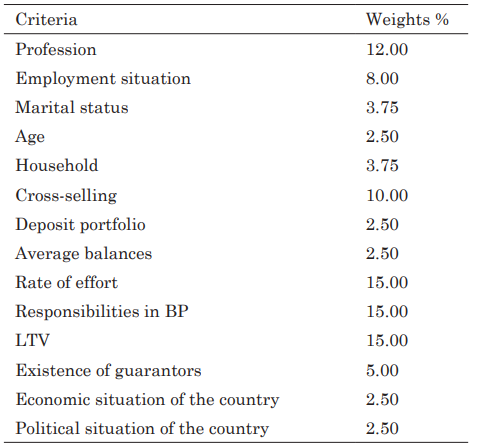

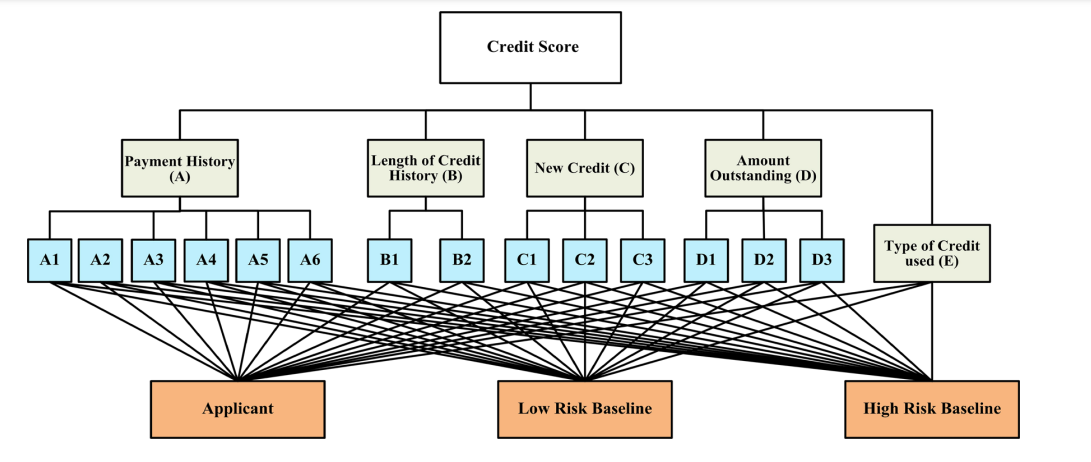

In [ ]:
Dtav=dn_norm.var()
Dtav

acc_now_delinq                1.0
acc_open_past_24mths          1.0
all_util                      1.0
annual_inc                    1.0
avg_cur_bal                   1.0
bc_open_to_buy                1.0
bc_util                       1.0
chargeoff_within_12_mths      1.0
collection_recovery_fee       1.0
collections_12_mths_ex_med    1.0
delinq_2yrs                   1.0
delinq_amnt                   1.0
dti                           1.0
fico_range_high               1.0
fico_range_low                1.0
funded_amnt                   1.0
funded_amnt_inv               1.0
il_util                       1.0
inq_fi                        1.0
inq_last_12m                  1.0
inq_last_6mths                1.0
installment                   1.0
int_rate                      1.0
last_fico_range_high          1.0
last_fico_range_low           1.0
last_pymnt_amnt               1.0
loan_amnt                     1.0
max_bal_bc                    1.0
mo_sin_old_il_acct            1.0
mo_sin_old_rev

In [ ]:
Dtav=dn_norm.var()<=0.5
Dtavf=pd.DataFrame(Dtav).reset_index()
Dtavf

,index,0
0,acc_now_delinq,True
1,acc_open_past_24mths,False
2,all_util,False
3,annual_inc,False
4,avg_cur_bal,False
5,bc_open_to_buy,False
6,bc_util,False
7,chargeoff_within_12_mths,True
8,collection_recovery_fee,False
9,collections_12_mths_ex_med,True


In [ ]:
min_max_scaler

MinMaxScaler()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#import hvplot.pandas

pd.options.display.max_rows = 0
pd.options.display.max_columns = 0

# ***Data reading***

In [ ]:
Data = pd.read_csv('/content/drive/MyDrive/Loan/Loan_status_2007-2020Q3.gzip')

In [ ]:
Data.shape

(2925493, 142)

In [ ]:
Data.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)

In [ ]:
Data = Data.drop(columns=['Unnamed: 0'])

In [ ]:
Data["issue_d"] = pd.to_datetime(Data["issue_d"])
Data = Data.loc[(Data['issue_d'] >= '2015-08-01')]

In [ ]:
Data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
230717,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,2017-09-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37%,16.0,w,0.00,0.00,13500.44,13500.44,...,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
230718,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,MORTGAGE,155000.0,Source Verified,2017-09-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,12.35,2.0,Sep-2005,715.0,719.0,1.0,10.0,NaN,20.0,0.0,48309.0,34.1%,42.0,w,6158.89,6158.89,31838.67,31838.67,...,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,CVD19SKIP,INCOMECURT,ACTIVE,2.0,0.00,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
230719,119321612,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,Driver,9 years,MORTGAGE,120000.0,Verified,2017-09-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,778xx,TX,31.11,0.0,Apr-2002,765.0,769.0,0.0,NaN,NaN,12.0,0.0,13389.0,20.7%,26.0,w,22376.90,22376.90,30417.91,30417.91,...,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,367745.0,154261.0,64600.0,168145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
230720,120122034,16000.0,16000.0,16000.0,36 months,7.97%,501.17,A,A5,Senior Investigator,5 years,RENT,79077.0,Not Verified,2017-09-01,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,223xx,VA,15.94,0.0,Jun-2000,700.0,704.0,0.0,38.0,NaN,12.0,0.0,16217.0,57.7%,20.0,w,2455.43,2455.43,15527.57,15527.57,...,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,128572.0,3700.0,96918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
230721,118659541,33000.0,33000.0,33000.0,36 months,7.21%,1022.12,A,A3,Registered Nurse,< 1 year,MORTGAGE,107000.0,Verified,2017-09-01,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,750xx,TX,19.06,0.0,Dec-2005,785.0,789.0,0.0,NaN,NaN,25.0,0.0,18533.0,16.1%,52.0,w,9873.08,9873.08,26616.93,26616.93,...,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,404510.0,48219.0,81700.0,73015.0,48968.0,705.0,709.0,Feb-2007,0.0,2.0,13.0,81.4,2.0,28.0,0.0,0.0,Y,ST0650PV01,UNEMPLOYED,ACTIVE,3.0,1022.12,Feb-2020,Apr-2020,Feb-2020,3.0,21.0,DELINQUENT,177

# ***Data loss is evidenced***

In [ ]:
Data.isna().sum()

id                                                  0
loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
installment                                         0
grade                                               0
sub_grade                                           0
emp_title                                      224583
emp_length                                     172326
home_ownership                                      0
                                               ...   
deferral_term                                 2091748
hardship_amount                               2053926
hardship_start_date                           2091748
hardship_end_date                             2091748
payment_plan_start_date                       2091748
hardship_length             

In [ ]:
Data_Loss = pd.DataFrame(index = Data.isna().sum().keys())
Data_Loss['Value'] = Data.isna().sum()
Data_Loss.reset_index(inplace=True)
Data_Loss.rename(columns = {'index':'Columns'}, inplace = True)
Data_Loss = pd.pivot_table(Data_Loss, values='Value', columns = ['Columns'])

In [ ]:
Data_Loss

Columns,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,deferral_term,delinq_2yrs,delinq_amnt,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,...,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
Value,0,0,0,174076,0,2022570,0,100,26503,27584,0,0,0,0,2091748,0,0,3108,2022574,0,172326,224583,0,0,0,0,0,2053926,2091749,2091748,37819,2053926,2091748,2091974,2053926,2091754,2091748,2091751,2091748,0,...,0,0,0,0,2035260,2233,2035259,2035259,2035259,2035259,2035259,2035259,2035259,2035259,2035259,2035259,2038496,0,0,0,23305,0,0,0,0,0,173720,0,173721,0,0,0,0,0,0,0,0,0,2038296,1


In [ ]:
Data = Data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
             'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
             'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']]

# ***EDA***

In [ ]:
Data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233083 entries, 230717 to 2925492
Data columns (total 26 columns):
 #   Column                Dtype         
---  ------                -----         
 0   loan_amnt             float64       
 1   term                  object        
 2   int_rate              object        
 3   installment           float64       
 4   grade                 object        
 5   sub_grade             object        
 6   emp_title             object        
 7   emp_length            object        
 8   home_ownership        object        
 9   annual_inc            float64       
 10  verification_status   object        
 11  issue_d               datetime64[ns]
 12  loan_status           object        
 13  purpose               object        
 14  title                 object        
 15  dti                   float64       
 16  earliest_cr_line      object        
 17  open_acc              float64       
 18  pub_rec               float64       


In [ ]:
Data.describe()

,loan_amnt,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,total_acc,mort_acc,pub_rec_bankruptcies
count,2.233083e+06,2.233083e+06,2.233083e+06,2.229975e+06,2.233083e+06,2.233083e+06,2.233083e+06,2.233083e+06,2.233083e+06,2.233083e+06
mean,1.559127e+04,4.576808e+02,8.174234e+04,1.974772e+01,1.175126e+01,1.738010e-01,1.707209e+04,2.363428e+01,1.433720e+00,1.249201e-01
std,9.786771e+03,2.813290e+02,1.235354e+05,1.738684e+01,5.884908e+00,5.146610e-01,2.338830e+04,1.214369e+01,1.782657e+00,3.536600e-01
min,1.000000e+03,7.610000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,2.514000e+02,4.800000e+04,1.219000e+01,8.000000e+00,0.000000e+00,5.854000e+03,1.500000e+01,0.000000e+00,0.000000e+00
50%,1.320000e+04,3.821700e+02,6.800000e+04,1.833000e+01,1.100000e+01,0.000000e+00,1.138100e+04,2.200000e+01,1.000000e+00,0.000000e+00
75%,2.100000e+04,6.156600e+02,9.800000e+04,2.534000e+01,1.500000e+01,0.000000e+00,2.064600e+04,3.000000e+01,2.000000e+00,0.000000e+00
max,4.000000e+04,1.719830e+03,1.100000e+08,9.990000e+02,1.040000e+02,8.600000e+01,2.559552e+06,1.760000e+02,9.400000e+01,9.000000e+00


In [ ]:
Data['loan_status'].value_counts()

Current               1026252
Fully Paid             933437
Charged Off            242302
Late (31-120 days)      15986
In Grace Period          9934
Late (16-30 days)        2695
Issued                   2062
Default                   415
Name: loan_status, dtype: int64

In [ ]:
Data.drop(Data.loc[Data['loan_status']=='Late (31-120 days)'].index, inplace=True)
Data.drop(Data.loc[Data['loan_status']=='In Grace Period'].index, inplace=True)
Data.drop(Data.loc[Data['loan_status']=='Late (16-30 days)'].index, inplace=True)
Data.drop(Data.loc[Data['loan_status']=='Issued'].index, inplace=True)
Data.drop(Data.loc[Data['loan_status']=='Default'].index, inplace=True)

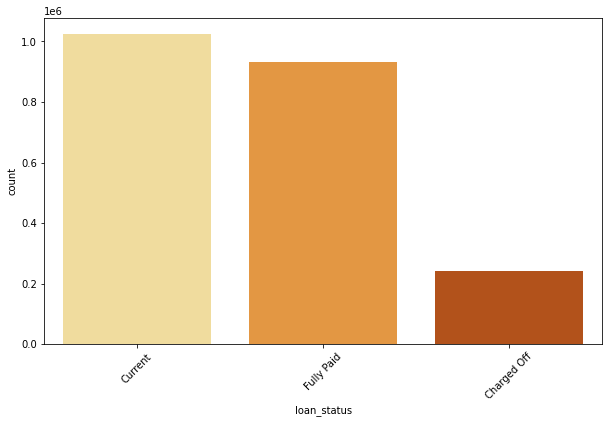

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'loan_status', data = Data, palette='YlOrBr', order=["Current", "Fully Paid", "Charged Off"])
plt.xticks(rotation=45)
plt.show()

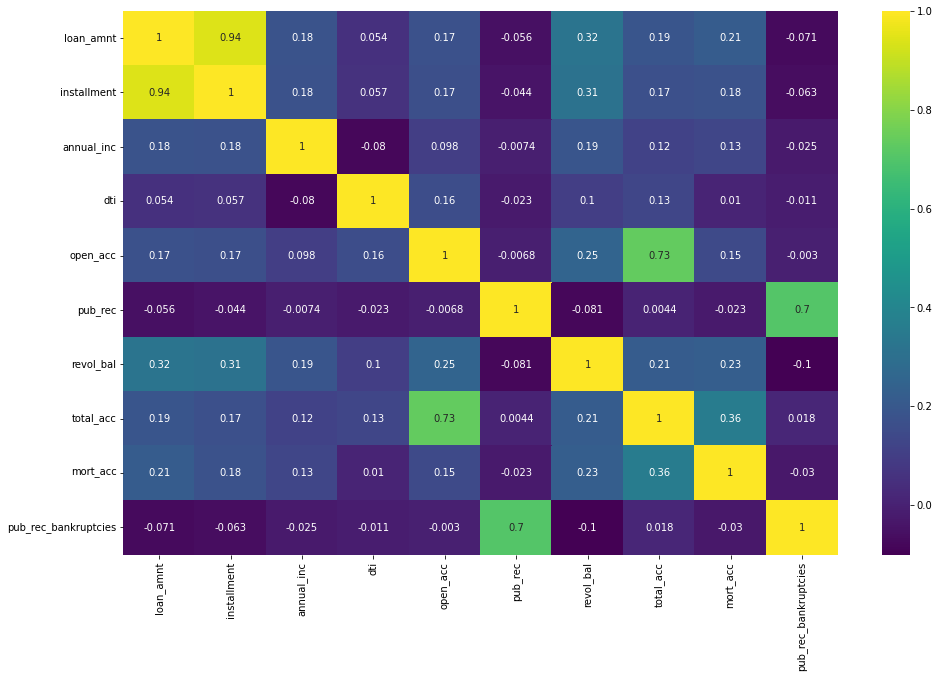

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(Data.corr(), annot=True, cmap='viridis')

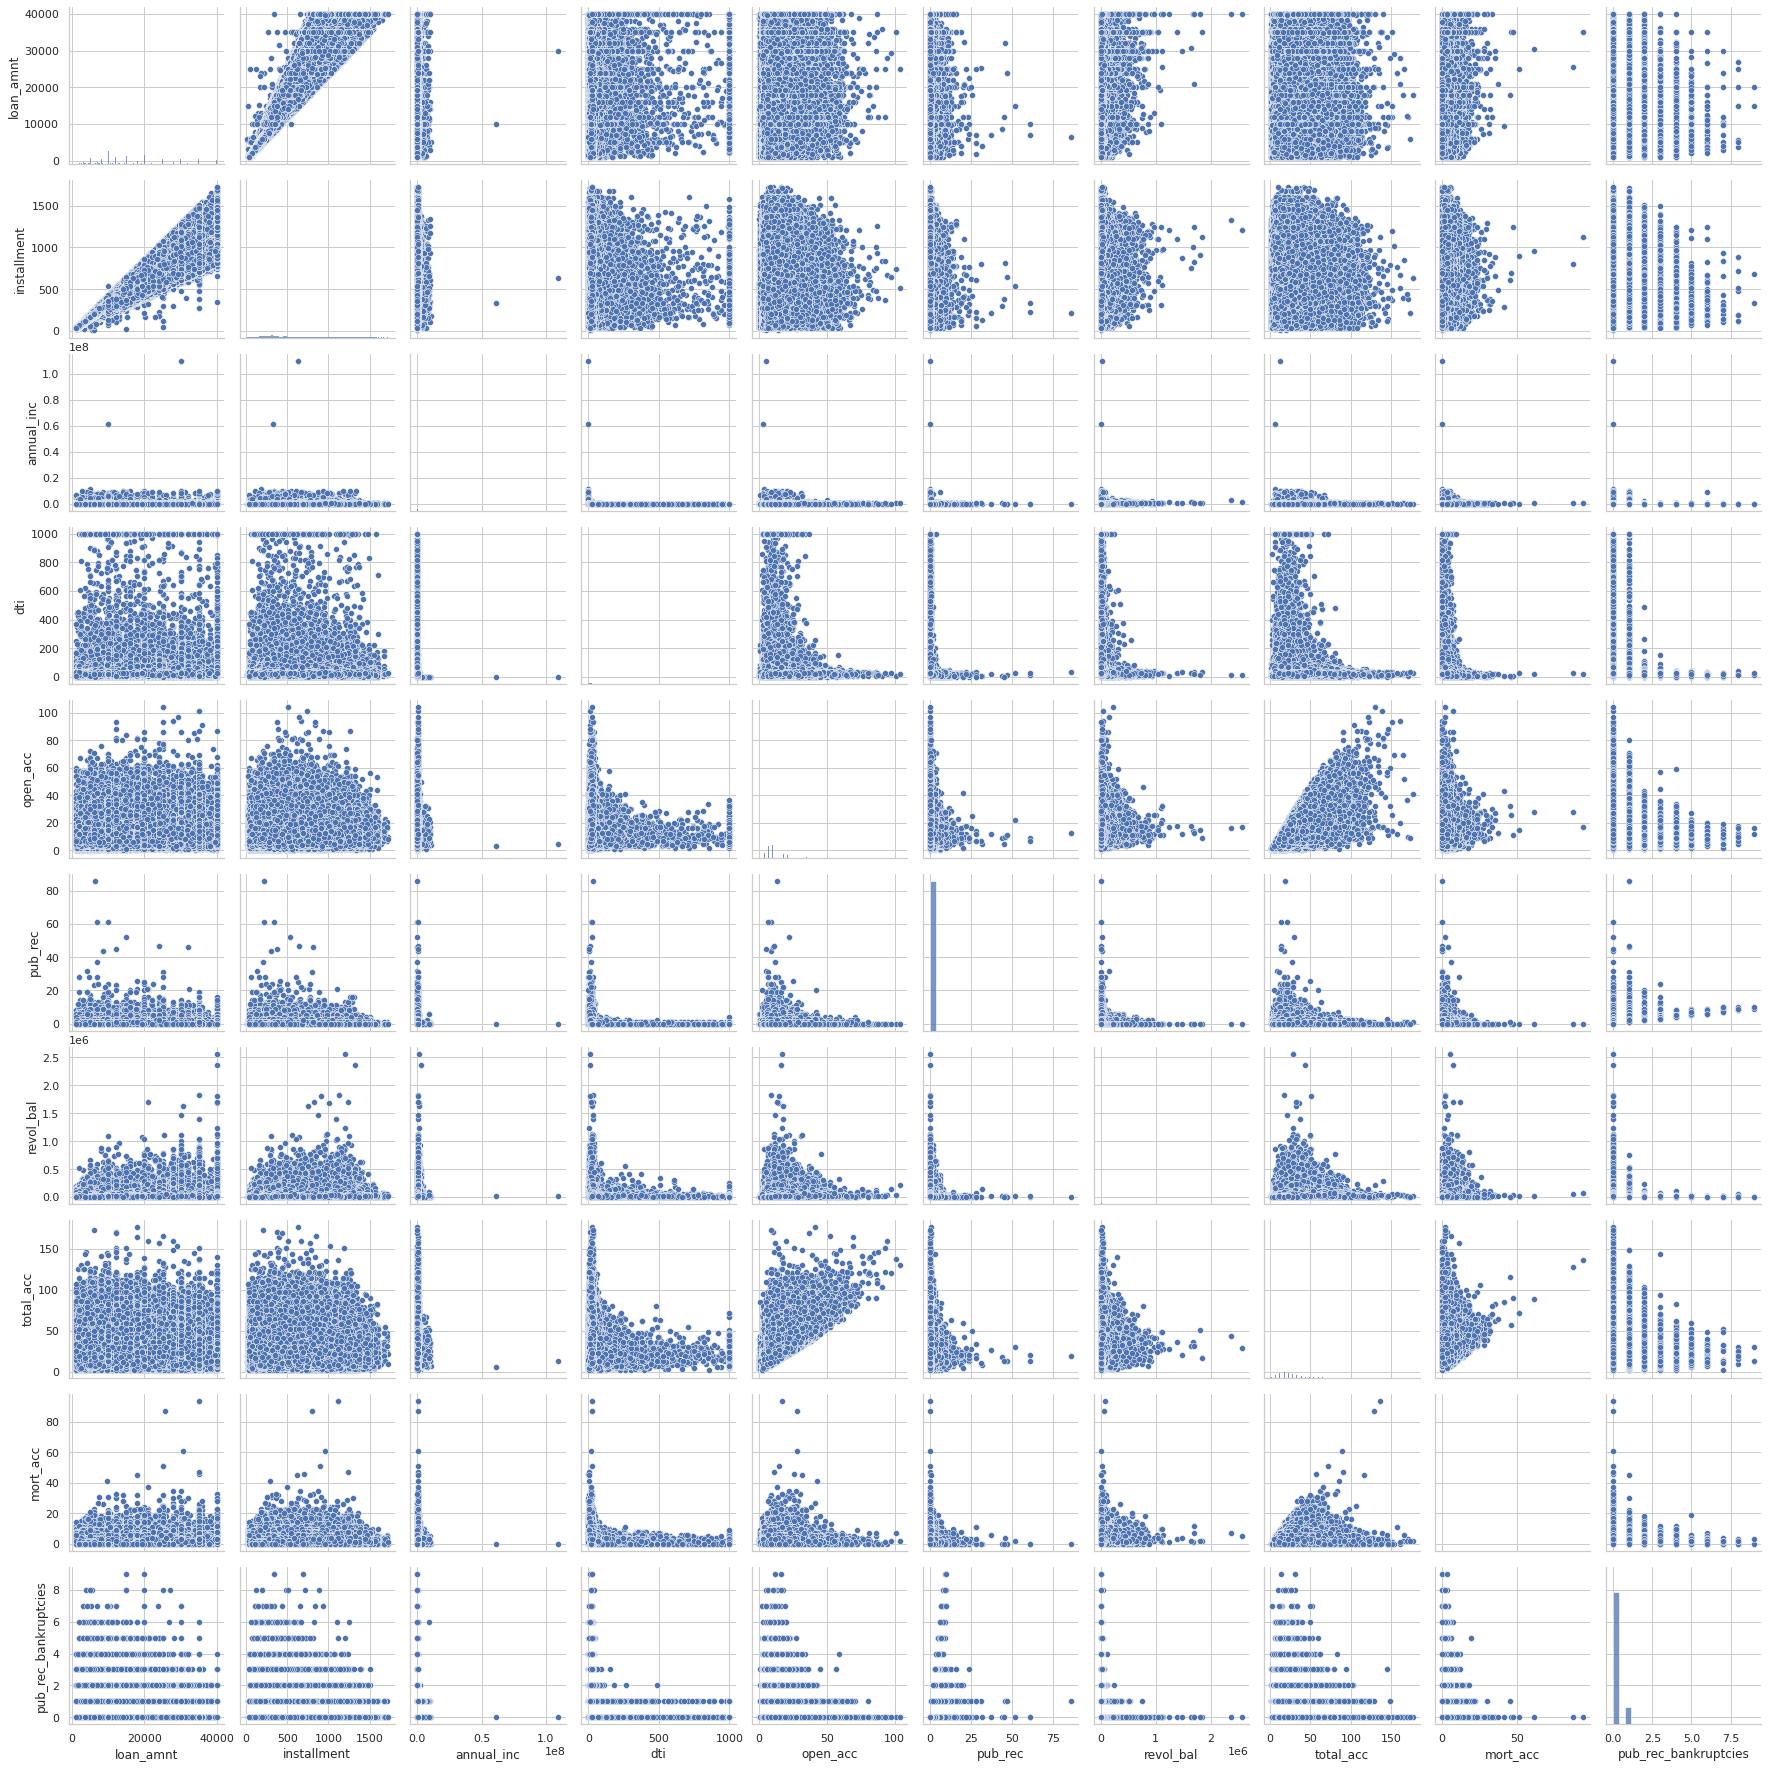

In [ ]:
sns.pairplot(Data)

***Installment:*** The monthly payment due from the borrower if the loan is originated.

***loan_amnt:*** The amount of the loan requested by the borrower. If at any time, the credit department reduces the loan amount, then it will be reflected in this value.

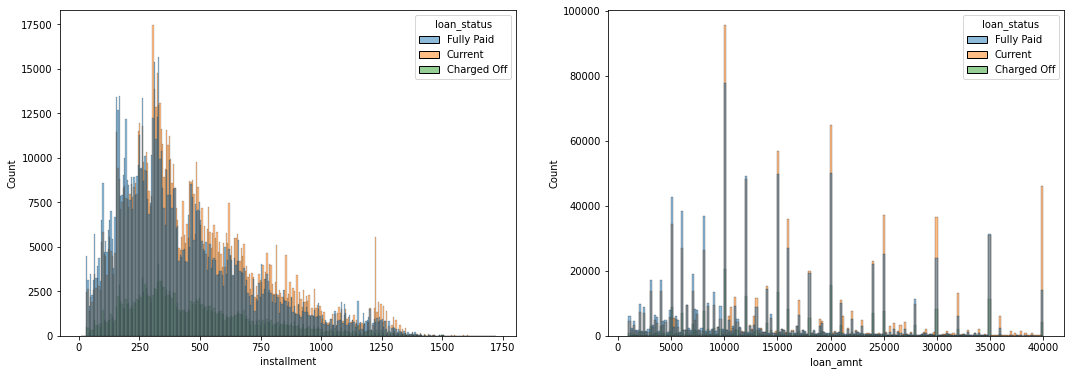

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#create chart in each subplot
sns.histplot(data=Data, x='installment', hue='loan_status', ax=axes[0])
sns.histplot(data=Data, x='loan_amnt', hue='loan_status', ax=axes[1])

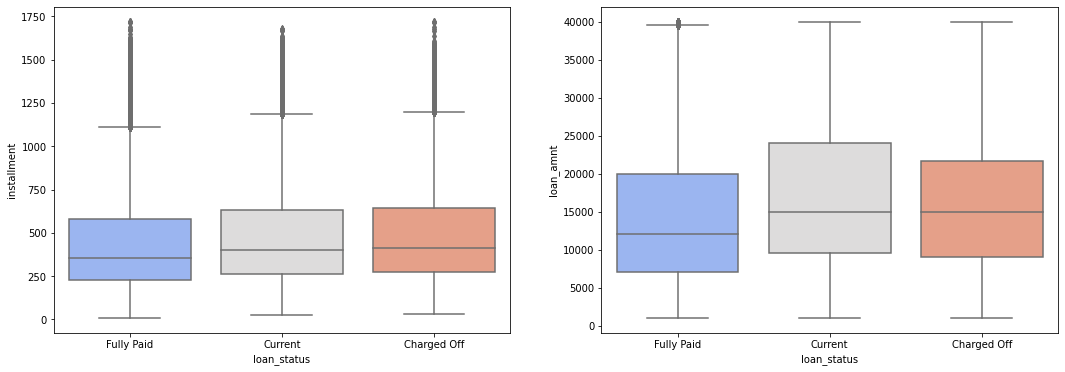

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#create chart in each subplot
sns.boxplot(data=Data, x='loan_status', y='installment', palette='coolwarm', ax=axes[0])
sns.boxplot(data=Data, x='loan_status', y='loan_amnt', palette='coolwarm', ax=axes[1])

In [ ]:
Data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,242302.0,16103.402469,9409.484517,1000.0,9000.0,15000.0,21600.0,40000.0
Current,1026252.0,16690.447375,10180.570759,1000.0,9600.0,15000.0,24000.0,40000.0
Fully Paid,933437.0,14194.432217,9243.084121,1000.0,7000.0,12000.0,20000.0,40000.0


***home_ownership:*** The homeownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENTAL, OWNERSHIP, MORTGAGE, OTHER

In [ ]:
Data['home_ownership'].value_counts()

MORTGAGE    1077272
RENT         859562
OWN          261714
ANY            3438
NONE              5
Name: home_ownership, dtype: int64

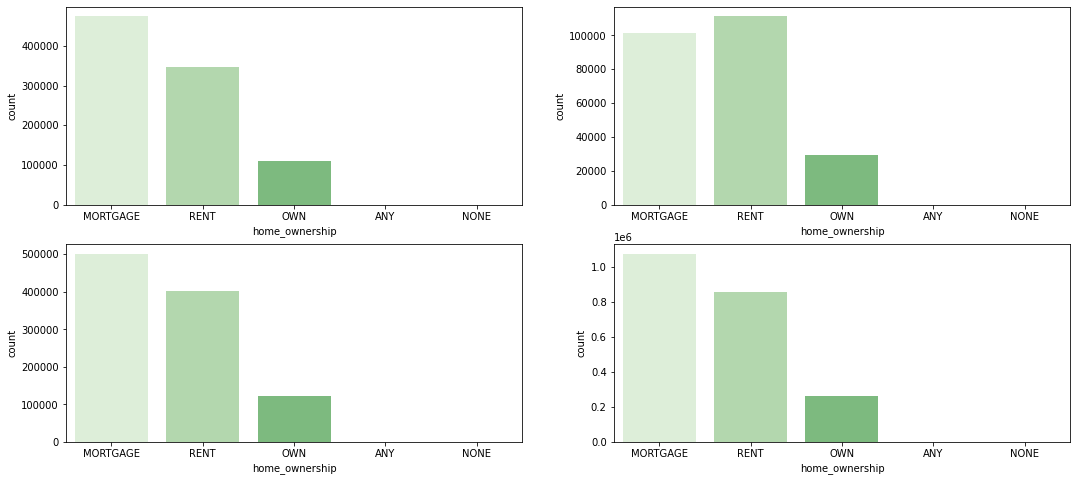

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))

sns.countplot(x = 'home_ownership', data = Data.loc[Data['loan_status']=='Fully Paid'], palette='Greens', ax=axes[0,0], order=["MORTGAGE", "RENT", "OWN", "ANY", "NONE"])
sns.countplot(x = 'home_ownership', data = Data.loc[Data['loan_status']=='Charged Off'], palette='Greens', ax=axes[0,1], order=["MORTGAGE", "RENT", "OWN", "ANY", "NONE"])
sns.countplot(x = 'home_ownership', data = Data.loc[Data['loan_status']=='Current'], palette='Greens', ax=axes[1,0], order=["MORTGAGE", "RENT", "OWN", "ANY", "NONE"])
sns.countplot(x = 'home_ownership', data = Data, palette='Greens', ax=axes[1,1], order=["MORTGAGE", "RENT", "OWN", "ANY", "NONE"])

In [ ]:
Data.loc[(Data.home_ownership == 'ANY') | (Data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
Data.home_ownership.value_counts()

MORTGAGE    1077272
RENT         859562
OWN          261714
OTHER          3443
Name: home_ownership, dtype: int64

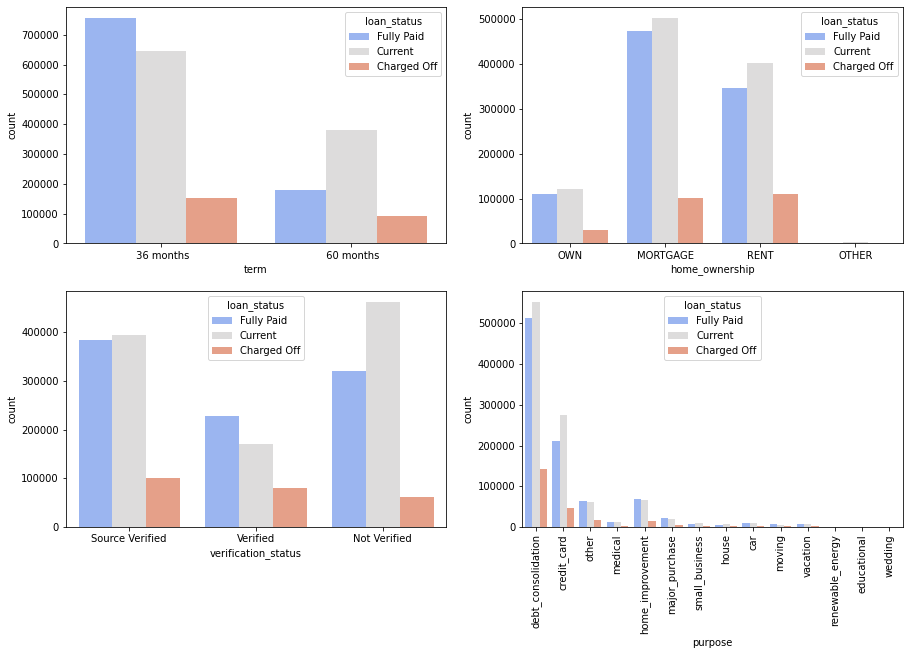

In [ ]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=Data, hue='loan_status', palette='coolwarm')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=Data, hue='loan_status', palette='coolwarm')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=Data, hue='loan_status', palette='coolwarm')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=Data, hue='loan_status', palette='coolwarm')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
Data.loc[Data['home_ownership']=='OTHER', 'loan_status'].value_counts()

Current        2267
Fully Paid      937
Charged Off     239
Name: loan_status, dtype: int64

# ***Cleaning for models***

(1) Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

(In PROCESS) Current: Loan is up to date on all outstanding payments.  

(In PROCESS) Issued: New loan that has passed all LendingClub reviews, received full funding, and has been issued.

(MORA) In Grace Period: Loan is past due but within the 15-day grace period. 

(MORA) Late (16-30): Loan has not been current for 16 to 30 days.
 
(MORA) Late (31-120): Loan has not been current for 31 to 120 days.

(0) Default: Loan has not been current for an extended period of time.

(0) Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# load dataframe
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/Modelos_2015.feather'
df = pd.read_feather(file_name)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['addr_state', 'initial_list_status', 'emp_title'], axis=1, inplace=True)
df.drop(df.loc[df['last_fico']==0].index, inplace=True)
df["emp_length"].replace({"10+ years": 10, "9 years": 9, "5 years":5,
                       "< 1 year":0, "3 years":3, "4 years":4, '0':0,
                       '6 years':6, '2 years':2, '8 years':8, '7 years':7, 
                       '1 year':1}, inplace=True)
df.drop(df.loc[df['purpose']=='educational'].index, inplace=True)

df_score = df.drop(['loan_status'], axis=1)
df_score = df_score.reset_index().drop(['index'], axis=1)
df_score.to_feather("/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_Score.feather")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drop_values = ['Current', 'Issued', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)']
df = df[df['loan_status'].isin(drop_values) == False]
df['loan_status'].replace({'Fully Paid':1, 'Charged Off':0, 'Default':0}, inplace=True)

df_loan = df.reset_index().drop(['index'], axis=1)
df_loan.to_feather("/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_loan.feather")

In [ ]:
len(df_loan)

1176119

In [ ]:
len(df_score)

2233040

# Random forest

## Random Forest to score

### Model with all variables

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# load dataframe
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_Score.feather'
df = pd.read_feather(file_name)

# Getting a sample of the df
df_sample = df.sample(n=500000, random_state=42)

# Managing dummies
df_dum = pd.get_dummies(df_sample)

X = df_dum.drop(['last_fico'], axis=1)
y = df_dum['last_fico']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

# create regressor object
regressor = RandomForestRegressor(n_estimators = 50, random_state = 42)
 
# fit the regressor with x and y data
regressor.fit(train_features, train_labels) 

RandomForestRegressor(n_estimators=50, random_state=42)

In [ ]:
# Use the forest's predict method on the test data
predictions = regressor.predict(test_features)

In [ ]:
import numpy as np

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 53.84 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.39 %.


In [ ]:
feature_list = list(df_dum.columns)

# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: int_rate             Importance: 0.13
Variable: annual_inc           Importance: 0.08
Variable: max_bal_bc           Importance: 0.07
Variable: loan_amnt            Importance: 0.06
Variable: installment          Importance: 0.06
Variable: percent_bc_gt_75     Importance: 0.06
Variable: tot_cur_bal          Importance: 0.06
Variable: total_acc            Importance: 0.06
Variable: dti                  Importance: 0.05
Variable: revol_util           Importance: 0.05
Variable: tot_hi_cred_lim      Importance: 0.05
Variable: last_fico            Importance: 0.03
Variable: mort_acc             Importance: 0.03
Variable: pct_tl_nvr_dlq       Importance: 0.03
Variable: mo_sin_old_rev_tl_op Importance: 0.02
Variable: delinq_amnt          Importance: 0.02
Variable: inq_last_6mths       Importance: 0.02
Variable: grade_A              Importance: 0.02
Variable: application_type_Joint App Importance: 0.01
Variable: grade_B              Importance: 0.01
Variable: purpose_car          Imp

### Model without variables with low importance


In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

drive.mount('/content/drive')

# load dataframe
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_Score.feather'
df = pd.read_feather(file_name)

df_importance = ['last_fico', 'int_rate', 'annual_inc', 'loan_amnt', 'dti', 
                 'total_acc', 'purpose', 'term', 'inq_last_6mths']
df = df[df_importance]

# Getting a sample of the df
df_sample = df.sample(n=500000, random_state=42)

# Managing dummies
df_dum = pd.get_dummies(df_sample)

X = df_dum.drop(['last_fico'], axis=1)
y = df_dum['last_fico']

# Split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

# create regressor object
regressor = RandomForestRegressor(n_estimators = 50, random_state = 42)
 
# fit the regressor with x and y data
regressor.fit(train_features, train_labels) 

# Use the forest's predict method on the test data
predictions = regressor.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean Absolute Error: 56.41 degrees.
Accuracy: 90.04 %.


In [ ]:
feature_list = list(df_dum.columns)

# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: loan_amnt            Importance: 0.23
Variable: last_fico            Importance: 0.21
Variable: int_rate             Importance: 0.17
Variable: annual_inc           Importance: 0.13
Variable: dti                  Importance: 0.13
Variable: total_acc            Importance: 0.03
Variable: purpose_car          Importance: 0.02
Variable: purpose_credit_card  Importance: 0.02
Variable: purpose_debt_consolidation Importance: 0.01
Variable: purpose_house        Importance: 0.01
Variable: purpose_moving       Importance: 0.01
Variable: purpose_wedding      Importance: 0.01
Variable: term_ 36 months      Importance: 0.01
Variable: inq_last_6mths       Importance: 0.0
Variable: purpose_home_improvement Importance: 0.0
Variable: purpose_major_purchase Importance: 0.0
Variable: purpose_medical      Importance: 0.0
Variable: purpose_other        Importance: 0.0
Variable: purpose_renewable_energy Importance: 0.0
Variable: purpose_small_business Importance: 0.0
Variable: purpose_vacation   

In [ ]:
# Save model
import joblib
joblib.dump(regressor, "/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_score_reg.joblib", compress=3)

['/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_score_reg.joblib']

## Random forest to Loan Status

### Model with all variables

In [ ]:
import pandas as pd

# load dataframe
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_loan.feather'
df = pd.read_feather(file_name)
# Getting a sample of the df
df2 = df.sample(n=500000, random_state=1)

# Managing dummies
df_dum = pd.get_dummies(df2)

X = df_dum.drop(['loan_status'], axis=1)
y = df_dum['loan_status']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Train model
from sklearn.ensemble import RandomForestClassifier
# create regressor object
classifier = RandomForestClassifier(n_estimators = 50, random_state = 42)
 
# fit the regressor with x and y data
classifier.fit(train_features, train_labels) 

y_pred_test = classifier.predict(test_features)

# View accuracy score
accuracy_score(test_labels, y_pred_test)*100

91.599

In [ ]:
confusion_matrix(test_labels, y_pred_test)

array([[16724,  3978],
       [ 4423, 74875]])

In [ ]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     20702
           1       0.95      0.94      0.95     79298

    accuracy                           0.92    100000
   macro avg       0.87      0.88      0.87    100000
weighted avg       0.92      0.92      0.92    100000



In [ ]:
feature_list = list(df_dum.columns)

# Get numerical feature importances
importances = list(classifier.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: last_fico            Importance: 0.54
Variable: int_rate             Importance: 0.04
Variable: dti                  Importance: 0.03
Variable: installment          Importance: 0.03
Variable: max_bal_bc           Importance: 0.03
Variable: mo_sin_old_rev_tl_op Importance: 0.03
Variable: revol_util           Importance: 0.03
Variable: tot_cur_bal          Importance: 0.03
Variable: tot_hi_cred_lim      Importance: 0.03
Variable: bc_open_to_buy       Importance: 0.03
Variable: loan_amnt            Importance: 0.02
Variable: pct_tl_nvr_dlq       Importance: 0.02
Variable: total_acc            Importance: 0.02
Variable: annual_inc           Importance: 0.02
Variable: mort_acc             Importance: 0.01
Variable: percent_bc_gt_75     Importance: 0.01
Variable: inq_last_6mths       Importance: 0.01
Variable: emp_length           Importance: 0.01
Variable: application_type_Joint App Importance: 0.01
Variable: purpose_wedding      Importance: 0.01
Variable: term_ 36 months      Imp

### Model without variables with low importance

In [ ]:
import pandas as pd

# load dataframe
file_name = '/content/drive/Shareddrives/DS4A/Credit Risk/Code/Data/BD_loan.feather'
df = pd.read_feather(file_name)

df_importance = ['loan_status', 'last_fico', 'int_rate', 'annual_inc', 
                 'loan_amnt', 'dti', 'total_acc', 'purpose', 'term', 'inq_last_6mths']

df = df[df_importance]

# Getting a sample of the df
df_sample = df.sample(n=500000, random_state=1)

# Managing dummies
df_dum = pd.get_dummies(df_sample)

X = df_dum.drop(['loan_status'], axis=1)
y = df_dum['loan_status']

In [ ]:
df_dum.columns

Index(['loan_status', 'last_fico', 'int_rate', 'annual_inc', 'loan_amnt',
       'dti', 'total_acc', 'inq_last_6mths', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Train model
from sklearn.ensemble import RandomForestClassifier
# create regressor object
classifier = RandomForestClassifier(n_estimators = 50, random_state = 42)
 
# fit the regressor with x and y data
classifier.fit(train_features, train_labels) 

y_pred_test = classifier.predict(test_features)

# View accuracy score
accuracy_score(test_labels, y_pred_test)*100

91.361

In [ ]:
confusion_matrix(test_labels, y_pred_test)

array([[16572,  4152],
       [ 4487, 74789]])

In [ ]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79     20724
           1       0.95      0.94      0.95     79276

    accuracy                           0.91    100000
   macro avg       0.87      0.87      0.87    100000
weighted avg       0.91      0.91      0.91    100000



In [ ]:
feature_list = list(df_dum.columns)

# Get numerical feature importances
importances = list(classifier.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: loan_status          Importance: 0.59
Variable: last_fico            Importance: 0.09
Variable: loan_amnt            Importance: 0.08
Variable: int_rate             Importance: 0.07
Variable: annual_inc           Importance: 0.06
Variable: dti                  Importance: 0.06
Variable: total_acc            Importance: 0.01
Variable: purpose_wedding      Importance: 0.01
Variable: term_ 36 months      Importance: 0.01
Variable: inq_last_6mths       Importance: 0.0
Variable: purpose_car          Importance: 0.0
Variable: purpose_credit_card  Importance: 0.0
Variable: purpose_debt_consolidation Importance: 0.0
Variable: purpose_home_improvement Importance: 0.0
Variable: purpose_house        Importance: 0.0
Variable: purpose_major_purchase Importance: 0.0
Variable: purpose_medical      Importance: 0.0
Variable: purpose_moving       Importance: 0.0
Variable: purpose_other        Importance: 0.0
Variable: purpose_renewable_energy Importance: 0.0
Variable: purpose_small_business Im

In [ ]:
# Save model
import joblib
joblib.dump(classifier, "/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_loan_clas.joblib", compress=3)

['/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_loan_clas.joblib']

## Predictions

### Score

Variables:

- int_rate
- annual_inc
- loan_amnt
- dti
- total_acc
- inq_last_6mths
- purpose_car
- purpose_credit_card
- purpose_debt_consolidation
- purpose_home_improvement
- purpose_house
- purpose_major_purchase
- purpose_medical
- purpose_moving
- purpose_other
- purpose_renewable_energy
- purpose_small_business
- purpose_vacation
- purpose_wedding
- term_ 36 months
- term_ 60 months

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor


drive.mount('/content/drive')

# Load model
loaded_rf = joblib.load("/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_score_reg.joblib")


import time
start_time = time.time()
# observation to predict
observation = [[7.89, 68000.00, 9000.00, 12.44, #int_rate, annual_inc, loan_amnt, dti, inq_last_6mths
              0.00, #inq_last_6mths
              30, #Grade A
              0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, #purpose debt_consolidation
              0.00, 0.00, 0.00, 0.00, 0.00, 
              1.00, 0.00 #term 36 months
              ]]

# Make the prediction
result_score = loaded_rf.predict(observation)
print("The predicted score is: ", result_score[0])
print("--- %s seconds ---" % (time.time() - start_time))

Mounted at /content/drive
The predicted score is:  665.74
--- 0.010870218276977539 seconds ---


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


### Loan

Variables:
- last_fico
- int_rate
- annual_inc
- loan_amnt
- dti
- total_acc
- inq_last_6mths
- purpose_car
- purpose_credit_card
- purpose_debt_consolidation
- purpose_home_improvement
- purpose_house
- purpose_major_purchase
- purpose_medical
- purpose_moving
- purpose_other
- purpose_renewable_energy
- purpose_small_business
- purpose_vacation
- purpose_wedding
- term_ 36 months
- term_ 60 months

In [ ]:
# Load model
loaded_rf = joblib.load("/content/drive/Shareddrives/DS4A/Credit Risk/Code/Models/rf_loan_clas.joblib")

# observation to predict
observation = [[result_score[0], 7.89, 68000.00, 9000.00, 12.44,  #last_fico, int_rate, annual_inc, loan_amnt, dti
              0.00, #Inq_last_6_months 
              30, #Grade A
              0.00, 0.00, 1.00, 0, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, #Purpose debt_consolidation 
              1.00, 0.00 # Term 36 months
              ]]

# Make the prediction
result_loan = loaded_rf.predict(observation)
print("The predicted score is: ", result_loan[0])

The predicted score is:  1


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
observation2 = [[570, 6, 200000.00, 10000.00, 6.98,  #last_fico, int_rate, annual_inc, loan_amnt, dti, inq_last_6mths
              0.00, #Inq_last_6_months 
              1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, #Grade A
              1.00, 0.00, 0.00, 0, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, #Purpose debt_consolidation 
              1.00, 0.00 # Term 36 months
              ]]
result_loan = loaded_rf.predict(observation2)
print("The predicted score is: ", result_loan[0])
#90	677.0	12.62	75000.0	25000.0	9.98	C	debt_consolidation	36 months	1.0	Charged Off